In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct
from array import array
from os.path  import join
from time import time
       

In [2]:
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test) 

Number of train samples: 60000
Number of test samples: 10000


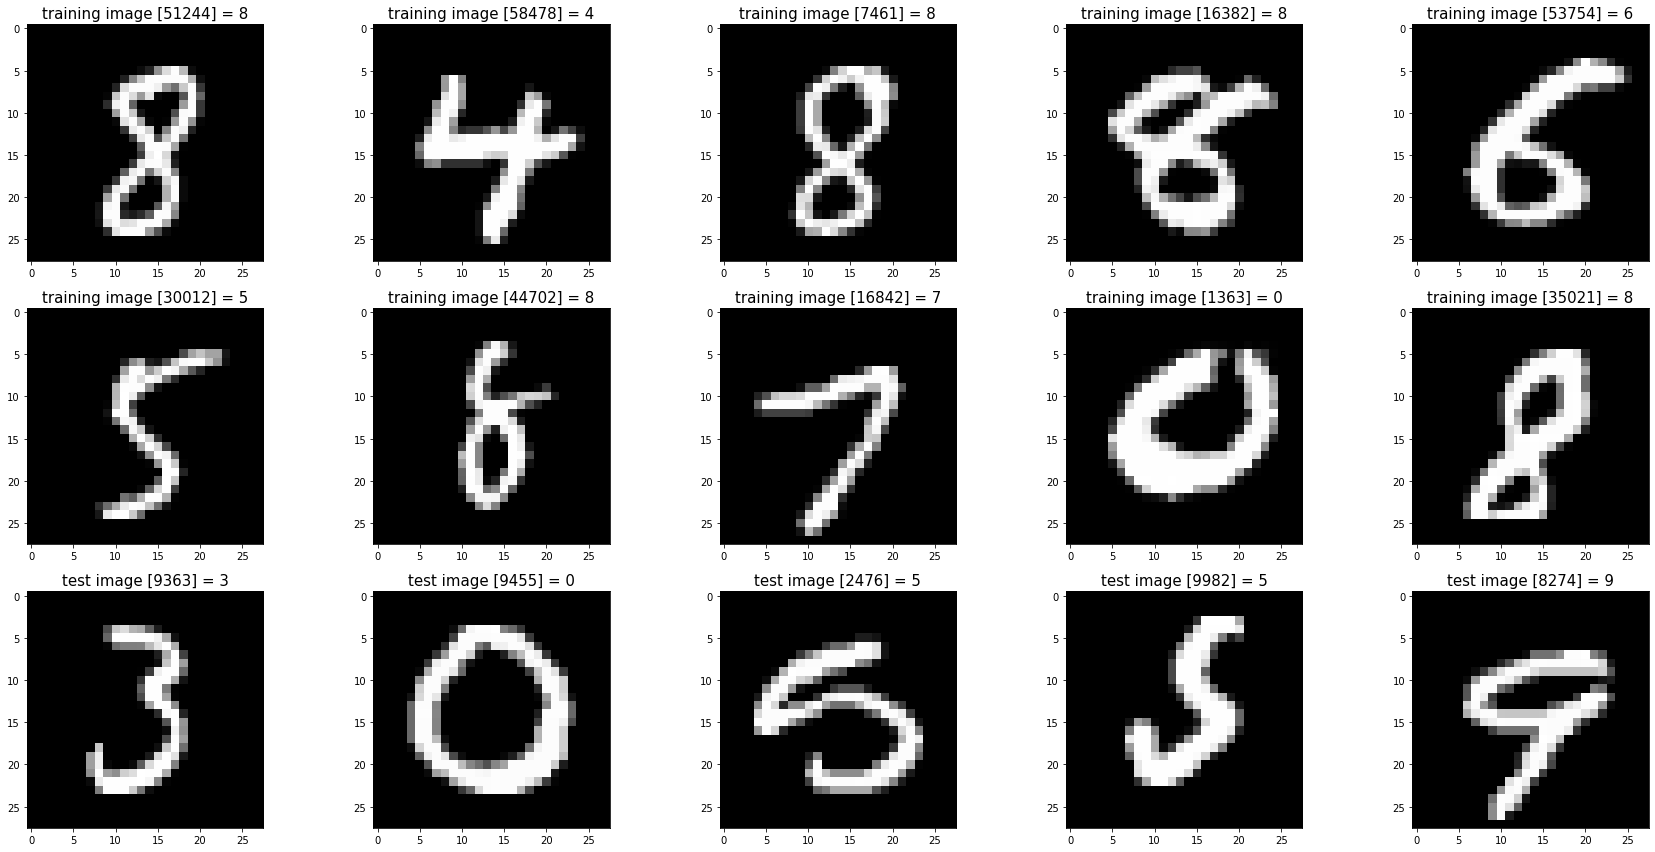

In [3]:
#
# Проверка чтения mnist
#
%matplotlib inline
import random

input_path = 'E:/учеба/глуб_обуч/лабы/1/mnist'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1


mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()
print('Number of train samples: {}'.format(len(x_train)))
print('Number of test samples: {}'.format(len(x_test)))
#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

In [4]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [5]:
def relu(x):
    return np.maximum(0, x)

# Производная ReLU для обратного распространения
def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def softmax(x):
    exps = np.exp(x )
    return exps / np.sum(exps, axis=1, keepdims=True)

In [6]:
# Функция потерь для конкретной эпохи
def cross_entropy(y_true, y_pred):
    n_samples = y_true.shape[0]
    logp = - np.log(y_pred[range(n_samples), y_true])
    return np.sum(logp) / n_samples

# Производная функции потерь для обратного распространения
def cross_entropy_derivative(y_true, y_pred):
    n_samples = y_true.shape[0]
    grad = y_pred
    grad[range(n_samples), y_true] -= 1
    return grad


In [7]:
def initialize_weights(input_size, hidden_size, output_size):
    W1 = np.random.randn(input_size, hidden_size) * 0.02
    b1 = np.zeros((1, hidden_size)) # смещение
    W2 = np.random.randn(hidden_size, output_size) * 0.02
    b2 = np.zeros((1, output_size))
    return W1, b1, W2, b2

In [8]:
# Прямое распространение
def forward_propagation(X, W1, b1, W2, b2):
    Z1 = X.dot(W1) + b1
    A1 = relu(Z1) 
    Z2 = A1.dot(W2) + b2 
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

In [9]:
# Обратное распространение
# Вычисление градиентов для обновления весов с помощью метода градиентного спуска.
def backward_propagation(X, y, Z1, A1,b1,b2, Z2, A2, W1, W2, learning_rate):
    m = X.shape[0]

    dZ2 = cross_entropy_derivative(y, A2)
    dW2 = A1.T.dot(dZ2)
    db2 = np.sum(dZ2, axis=0, keepdims=True)

    dA1 = dZ2.dot(W2.T)
    dZ1 = dA1 * relu_derivative(Z1)
    dW1 = X.T.dot(dZ1)
    db1 = np.sum(dZ1, axis=0, keepdims=True)

    W1 -= learning_rate * dW1 / m
    b1 -= learning_rate * db1 / m
    W2 -= learning_rate * dW2 / m
    b2 -= learning_rate * db2 / m

    return W1, b1, W2, b2

In [10]:
def train(x_train, y_train, x_test, y_test, hidden_size, learning_rate, batch_size, epochs):
    input_size = x_train.shape[1]
    output_size = len(np.unique(y_train))

    W1, b1, W2, b2 = initialize_weights(input_size, hidden_size, output_size)
    start_time = time()
    for epoch in range(epochs):
        # Перемешивание данных
        indices = np.random.permutation(x_train.shape[0])
        x_train = x_train[indices]
        y_train = y_train[indices]

        for i in range(0, x_train.shape[0], batch_size):
            X_batch = x_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            Z1, A1, Z2, A2 = forward_propagation(X_batch, W1, b1, W2, b2)

            W1, b1, W2, b2 = backward_propagation(X_batch, y_batch, Z1, A1,b1,b2, Z2, A2, W1, W2, learning_rate)

        # Оценка на тренировочной и тестовой выборках
        _, _, _, train_predictions = forward_propagation(x_train, W1, b1, W2, b2)
        train_loss = cross_entropy(y_train, train_predictions)
        train_acc = np.mean(np.argmax(train_predictions, axis=1) == y_train)
        
        _, _, _, test_predictions = forward_propagation(x_test, W1, b1, W2, b2)
        test_loss = cross_entropy(y_test, test_predictions)
        test_acc = np.mean(np.argmax(test_predictions, axis=1) == y_test)
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
        end_time = time()
        

        print(f'Train Accuracy: {train_acc:.4f}% , Test Accuracy: {test_acc:.4f}, time = {end_time - start_time:.3f} sec.')

In [11]:
input_size = 28 * 28
hidden_size = 300
output_size = 10
epochs = 20
batch_size = 20
learning_rate = 0.1
# Нормализация данных
X_train = x_train.reshape(-1, 28*28) / 255.0
X_test = x_test.reshape(-1, 28*28) / 255.0

train(X_train, y_train, X_test, y_test, hidden_size,learning_rate, batch_size,  epochs)


Epoch 1/20, Train Loss: 0.1433, Test Loss: 0.1450
Train Accuracy: 0.9588% , Test Accuracy: 0.9586, time = 5.808 sec.
Epoch 2/20, Train Loss: 0.0989, Test Loss: 0.1169
Train Accuracy: 0.9716% , Test Accuracy: 0.9650, time = 10.761 sec.
Epoch 3/20, Train Loss: 0.0600, Test Loss: 0.0869
Train Accuracy: 0.9835% , Test Accuracy: 0.9730, time = 16.496 sec.
Epoch 4/20, Train Loss: 0.0609, Test Loss: 0.0906
Train Accuracy: 0.9810% , Test Accuracy: 0.9717, time = 21.434 sec.
Epoch 5/20, Train Loss: 0.0349, Test Loss: 0.0665
Train Accuracy: 0.9907% , Test Accuracy: 0.9780, time = 27.307 sec.
Epoch 6/20, Train Loss: 0.0269, Test Loss: 0.0629
Train Accuracy: 0.9935% , Test Accuracy: 0.9792, time = 32.063 sec.
Epoch 7/20, Train Loss: 0.0250, Test Loss: 0.0675
Train Accuracy: 0.9935% , Test Accuracy: 0.9793, time = 37.620 sec.
Epoch 8/20, Train Loss: 0.0165, Test Loss: 0.0588
Train Accuracy: 0.9967% , Test Accuracy: 0.9816, time = 42.441 sec.
Epoch 9/20, Train Loss: 0.0138, Test Loss: 0.0631
Train A